In [1]:
import multiprocessing as mp
import os
import pickle
import random
import re
import sys
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tmap as tm
from faerun import Faerun
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors
from tqdm import tqdm
from tqdm.auto import trange

current_dir = os.getcwd()
parent_parent_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(parent_parent_dir, 'src')
sys.path.append(src_dir)

from util import *

RDLogger.DisableLog('rdApp.*')

In [2]:
df = pd.read_csv('../../data/processed/tdc/Tox/12_hERG_at_inhib_date.tsv', sep='\t')

In [3]:
def compute_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return None

In [4]:
smiles = []
years = []
ecfps = []

for i in trange(len(df)):
    smiles.append(df.iloc[i,0])
    years.append(int(df.iloc[i,2]))
    ecfps.append(compute_ecfp(df.iloc[i,0]))

  0%|          | 0/23782 [00:00<?, ?it/s]

In [5]:
tox = [df.iloc[i,1] for i in range(len(df))]

In [6]:
enc = tm.Minhash(128)
lf = tm.LSHForest(128)

d = 2048
n = len(smiles)

data = []
start = timer()
for x in trange(n):
    data.append(tm.VectorUchar(np.array(ecfps[x])))
print(f"Generating the data took {(timer() - start) * 1000}ms.", flush=True)

start = timer()
lf.batch_add(enc.batch_from_binary_array(data))
print(f"Adding the data took {(timer() - start) * 1000}ms.", flush=True)

start = timer()
lf.index()
print(f"Indexing took {(timer() - start) * 1000}ms.", flush=True)

start = timer()
knng_from = tm.VectorUint()
knng_to = tm.VectorUint()
knng_weight = tm.VectorFloat()

_ = lf.get_knn_graph(knng_from, knng_to, knng_weight, 10)
print(f"make knn graph {(timer() - start) * 1000}ms.", flush=True)

  0%|          | 0/23782 [00:00<?, ?it/s]

Generating the data took 83125.98600902129ms.
Adding the data took 35872.72170407232ms.
Indexing took 396.18062193039805ms.
make knn graph 11898.609181051143ms.


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.340e+02, 9.000e+01, 1.360e+02, 1.431e+03, 4.620e+02,
        3.880e+02, 3.160e+02, 3.310e+02, 3.290e+02, 2.530e+02, 1.890e+02,
        2.230e+02, 2.170e+02, 2.520e+02, 2.030e+02, 2.220e+02, 2.120e+02,
        2.230e+02, 1.930e+02, 1.900e+02, 1.720e+02, 2.090e+02, 2.320e+02,
        2.220e+02, 2.250e+02, 2.000e+02, 2.190e+02, 3.370e+02, 2.810e+02,
        3.440e+02, 4.210e+02, 7.640e+02, 7.030e+02, 5.360e+02, 1.434e+03,
        8.830e+02, 1.594e+03, 1.329e+03, 9.250e+02, 9.620e+02, 8.120e+02,
        9.500e+02, 7.830e+02, 4.980e+02, 7.480e+02, 2.850e+02, 2.850e+02,
        3.960e+02, 4.470e+02, 1.580e+02, 4.320e+02]),
 array([1966.        , 1966.98275862, 1967.96551724, 1968.94827586,
        1969.93103448, 1970.9137931 , 1971.89655172, 1972.87931034,
        1973.86206897, 1974.84482759, 1975.82758621, 1976.81034483,
        1977.79310345, 1978.77586207, 1979.75862069, 1980.74137931,
        

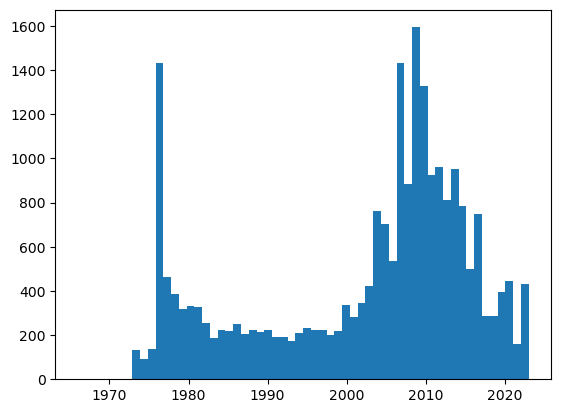

In [7]:
plt.hist(years, bins=58)

In [8]:
labels = []
for year in years:
    labels.append(max(1989, min(2018, year)))

(array([5390.,  223.,  193.,  190.,  172.,  209.,  232.,  222.,  225.,
         200.,  219.,  337.,  281.,  344.,  421.,  764.,  703.,  536.,
        1434.,  883., 1594., 1329.,  925.,  962.,  812.,  950.,  783.,
         498.,  748., 2003.]),
 array([1989.        , 1989.96666667, 1990.93333333, 1991.9       ,
        1992.86666667, 1993.83333333, 1994.8       , 1995.76666667,
        1996.73333333, 1997.7       , 1998.66666667, 1999.63333333,
        2000.6       , 2001.56666667, 2002.53333333, 2003.5       ,
        2004.46666667, 2005.43333333, 2006.4       , 2007.36666667,
        2008.33333333, 2009.3       , 2010.26666667, 2011.23333333,
        2012.2       , 2013.16666667, 2014.13333333, 2015.1       ,
        2016.06666667, 2017.03333333, 2018.        ]),
 <BarContainer object of 30 artists>)

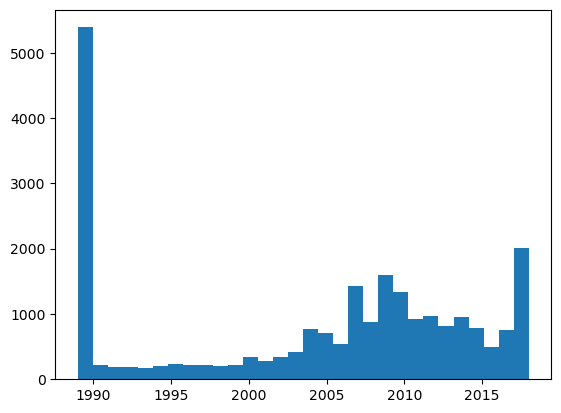

In [9]:
plt.hist(labels, bins=30)

In [10]:
blue = 0
red = 0

for i in range(len(labels)):
    if labels[i] < 1990:
        blue += 1
    elif labels[i] > 2012:
        red += 1

print(blue, red)

5390 5794


1989 2018 30


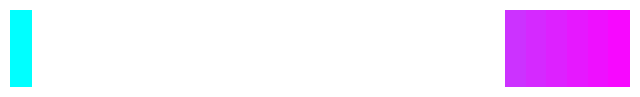

In [11]:
num_colors = min(labels)
total_colors = max(labels) - min(labels) + 1 

print(min(labels), max(labels), total_colors)

base_cmap = plt.get_cmap("cool")
colors = [base_cmap(i / total_colors) for i in range(total_colors)]

black_section = [(0, 0, 0, 0)] * num_colors  # 1973個の黒
new_colors = black_section + colors  # 1973個の黒 + 残りの色

MY_CM = LinearSegmentedColormap.from_list("my_map_black", new_colors, N=len(new_colors))

colors_section = new_colors[num_colors:]  

for i in range(1, len(colors_section)-6):
    colors_section[i] = (0, 0, 0, 0)

new_colors[num_colors:] = colors_section

MY_CM_SELECTED = LinearSegmentedColormap.from_list("my_map_black", colors_section, N=len(colors_section))
MY_CM_3 = LinearSegmentedColormap.from_list("my_map_black", new_colors, N=len(new_colors))

gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.figure(figsize=(8, 1))
plt.imshow(gradient, aspect="auto", cmap=MY_CM_SELECTED)
plt.axis("off")
plt.show()

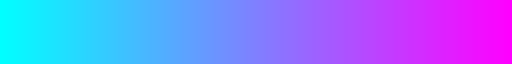

In [12]:
base_cmap

In [13]:
custom_cmap = ListedColormap(
    ["#ffffff", "#ff0000"],
    name="custom",
)

In [14]:
x, y, s, t, _ = tm.layout_from_lsh_forest(lf)

faerun = Faerun(clear_color="#111111", view="front", coords=False)

faerun.add_scatter(
    "tdc_12_hERG",
    {"x": x, "y": y, "c": [labels, labels, tox], "labels": smiles},
    colormap=[MY_CM, MY_CM_3, custom_cmap],
    shader="smoothCircle",
    series_title=["Year", "Year", "Tox"],
    point_scale=2.5,
    max_point_size=10,
    has_legend=True,
    categorical=True,
)
faerun.add_tree(
    "tdc_12_hERG_tree", {"from": s, "to": t}, point_helper="tdc_12_hERG", color="#666666"
)

faerun.plot("tdc_12_hERG", template="smiles")

/workspace/HDD1/user/ohto_2/1-project/2-tox_pred/2-patent_date_split/github/patent_time_split/notebook/experiment/tdc_12_hERG.html

In [15]:
def lsh_forest_purity(s, t, labels):
    matches = (labels[s] == labels[t])
    purity = np.sum(matches) / len(matches)
    return purity

labels = np.array(labels) 
lsh_purity_real = lsh_forest_purity(s, t, labels)

num_permutations = 1000
random_purities = []

for _ in trange(num_permutations):
    shuffled_labels = np.random.permutation(labels)
    random_purity = lsh_forest_purity(s, t, shuffled_labels)
    random_purities.append(random_purity)

random_purities = np.array(random_purities)
p_value = np.mean(random_purities >= lsh_purity_real)


print(f"LSH Forest Edge Purity (Real): {lsh_purity_real:.4f}")
print(f"Mean Random Purity: {random_purities.mean():.4f}")
print(f"p-value: {p_value:.4f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

LSH Forest Edge Purity (Real): 0.3061
Mean Random Purity: 0.0836
p-value: 0.0000
